# Stage 1: Importing dependencies.

In [34]:
import numpy as np
import math
import re
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers


# Stage 2: Data preprocessing

## Loading files

In [3]:
cols = ["sentiment", "id", "date", "query", "user", "text"]
train_data = pd.read_csv(
    "train.csv",
    header=None,
    names=cols,
    engine="python",
    encoding="latin1"
)
test_data = pd.read_csv(
    "test.csv",
    header=None,
    names=cols,
    engine="python",
    encoding="latin1"
)

The test dataset has 3 different labels (a negative, a positive and a neutral one) while the train dataset has only two so we will not use the test file, and split the train file later by ourselves.


In [4]:
data = train_data

## Preprocessing

### Cleaning

In [5]:
data.drop(["id", "date", "query", "user"], # don't forget to run data = train_data before!
          axis=1,
          inplace=True)

In [9]:
def clean_tweet(tweet):
    #tweet = BeautifulSoup(tweet, "lxml").get_text()
    # Removing the @
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
    # Removing the URL links
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
    # Keeping only letters
    tweet = re.sub(r"[^a-zA-Z.!?']", ' ', tweet)
    # Removing additional whitespaces
    tweet = re.sub(r" +", ' ', tweet)
    return tweet

In [10]:
data_clean = [clean_tweet(tweet) for tweet in data.text]

In [11]:
data_labels = data.sentiment.values
data_labels[data_labels == 4] = 1

### Tokenization

 it takes a set of words and breaks it up in a set of known words in dictionary (or vocabulary). For example, "badwords" is broken up in "bad" and "words". This process is key for good quality natural language processing. 
 It assigns each word a unique number. "a" != " a"

In [15]:
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    data_clean, target_vocab_size=2**16
)

data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

In [20]:
# Encode, decode
ids = tokenizer.encode("Hello world")
assert tokenizer.decode(ids) == "Hello world"

In [21]:
tokenizer.encode("Ramya")

[11536, 776]

In [25]:
tokenizer.decode([11536])

'Ram'

In [26]:
tokenizer.decode([776])

'ya'

In [29]:
tokenizer.encode("badwords")

[626, 2786]

In [30]:
tokenizer.decode([626])

'bad'

In [31]:
tokenizer.decode([2786])

'words'

### Padding

In [16]:
MAX_LEN = max([len(sentence) for sentence in data_inputs])
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value=0,
                                                            padding="post",
                                                            maxlen=MAX_LEN)

### Spliting into training/testing set



In [17]:
test_idx = np.random.randint(0, 800000, 8000)
test_idx = np.concatenate((test_idx, test_idx+800000))

In [18]:
test_inputs = data_inputs[test_idx]
test_labels = data_labels[test_idx]
train_inputs = np.delete(data_inputs, test_idx, axis=0)
train_labels = np.delete(data_labels, test_idx)

https://arxiv.org/pdf/1703.03091.pdf



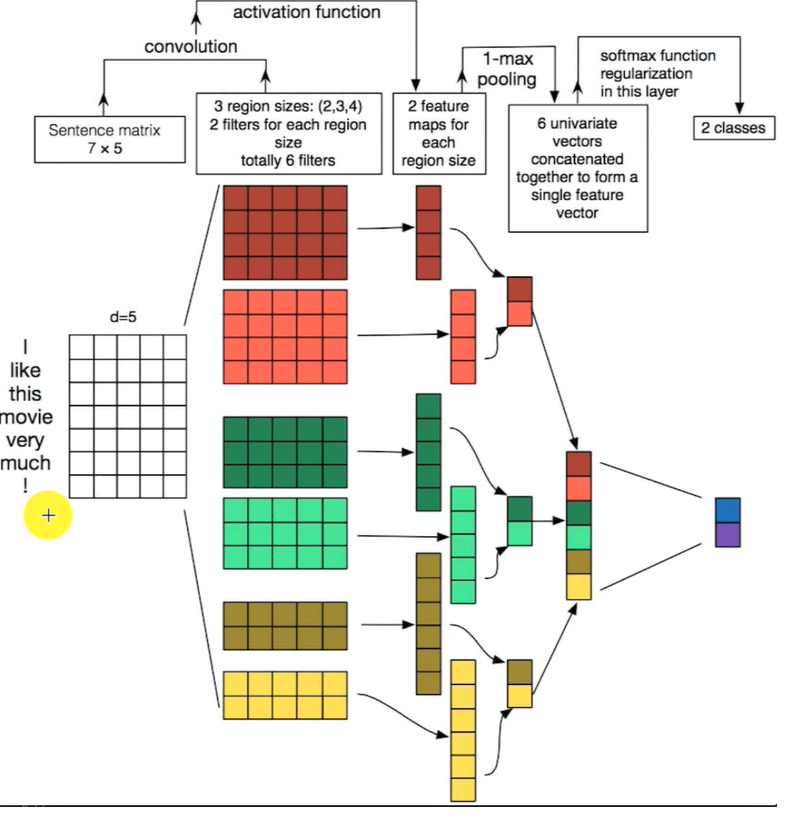

# Stage 3: Model building

class DerivedClass(BaseClass):\
  Body of derived class

In [19]:
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 nb_filters=50,
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="dcnn"):
        super(DCNN, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocab_size,
                                          emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="valid",
                                     activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="valid",
                                      activation="relu")
        self.pool = layers.GlobalMaxPool1D() # no training variable so we can
                                             # use the same layer for each
                                             # pooling step
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        
        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)
        
        return output

# Stage 4: Application

## Config

In [32]:
VOCAB_SIZE = tokenizer.vocab_size

EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2#len(set(train_labels))

DROPOUT_RATE = 0.2

BATCH_SIZE = 32
NB_EPOCHS = 5

## Training

In [35]:
Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

In [36]:
if NB_CLASSES == 2:
    Dcnn.compile(loss="binary_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])
else:
    Dcnn.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])

In [38]:
#checkpoint is way to store our model, no need to start from scratch

checkpoint_path = "C:/Users/ramya/Desktop/Santa Clara University/Projects/Deep learning/NLP with CNN/"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!!")

In [ ]:
Dcnn.fit(train_inputs,
         train_labels,
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS)
ckpt_manager.save()

Epoch 1/5
49503/49503 [==============================] - 12076s 244ms/step - loss: 0.3977 - accuracy: 0.8205
Epoch 2/5
 6017/49503 [==>...........................] - ETA: 3:27:53 - loss: 0.3258 - accuracy: 0.8606

## Evaluation

In [ ]:
results = Dcnn.evaluate(test_inputs, test_labels, batch_size=BATCH_SIZE)
print(results)

In [ ]:
Dcnn(np.array([tokenizer.encode("bad teacher")]), training=False)